In [13]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm import tqdm
import umap
import os, sys
import random
import argparse
import torch
import scipy
from datetime import datetime
from sklearn.model_selection import train_test_split
# from Conv4_VAE_Functions import *
from Resnet18_VAE_Functions import *
# from Resnet34_VAE_Functions import *

In [2]:
torch.manual_seed(2024)
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device, torch.cuda.get_device_name())

cuda:0 NVIDIA A100-SXM4-40GB


In [28]:
X = np.load('data_Nuci,Nuc,Nsk,Mit,Gol,ER,Cel,Cyt_10000-max.npy')
print(X.min(), X.max())

0.0 1.0


In [4]:
X_Shuffle = X.copy()
np.random.shuffle(X_Shuffle)
f1 = int(0.8*len(X_Shuffle))
f2 = int(0.9*len(X_Shuffle))
X_train = X_Shuffle[:f1]
X_val = X_Shuffle[f1:f2]
X_test = X_Shuffle[f2:]

X_train = torch.tensor(X_train, dtype=torch.float32)
X_val = torch.tensor(X_val, dtype=torch.float32)
X_test = torch.tensor(X_val, dtype=torch.float32)

V = 'ResNet18_8-loc_ch-1'
K = 16

C = X.shape[1]
save_path = V + '_K-' + str(K) + '_Ch-' + str(C)

if not (os.path.isdir(save_path)):
    os.mkdir(save_path)

/tmp/ipykernel_2005804/2648285988.py:10: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  X_test = torch.tensor(X_val, dtype=torch.float32)


In [5]:
B = 64
vae = VAE(K, C)
vae.to(device)

VAE(
  (encoder): ResNet18Enc(
    (conv1): Conv2d(1, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (layer1): Sequential(
      (0): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (shortcut): Sequential()
      )
      (1): BasicBlockEnc(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    

In [8]:
vae.load_state_dict(torch.load('ResNet18_8-loc_ch-1_K-16_Ch-1/VAE_ResNet18_8-loc_ch-1_16.pt'))

<All keys matched successfully>

In [ ]:
train_losses, validation_losses = train_vae(vae, X_train, X_val, epochs=30, batch_size=B, lr=1e-4)

torch.save(vae.state_dict(), os.path.join(save_path, 'VAE_' + str(V) + '_' + str(K) + '_2.pt'))
print('done')

In [ ]:
Plot_History(train_losses, validation_losses)
plt.show()

In [ ]:
plt.plot(train_losses, label='training')
plt.plot(np.arange(0, len(validation_losses) * 4, 4), validation_losses, label='validation')
plt.legend()
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.show()

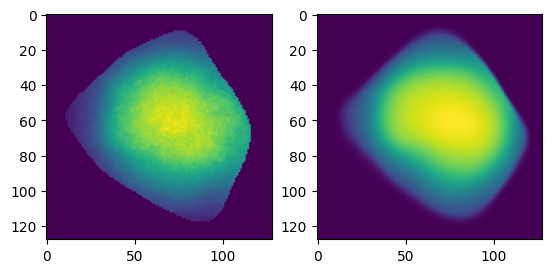

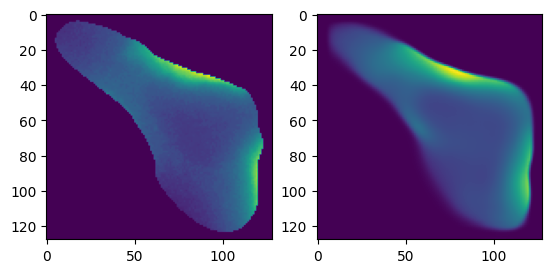

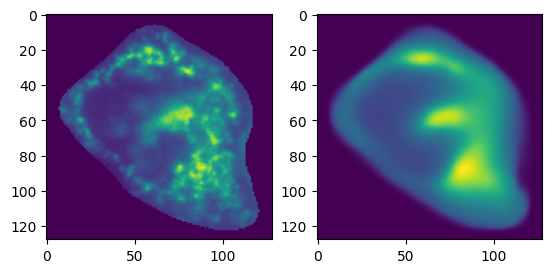

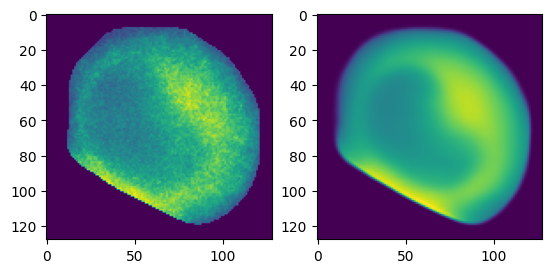

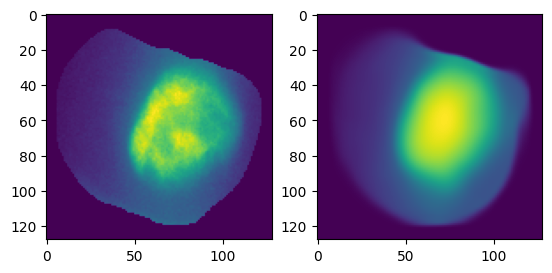

In [7]:
for idx in [1000, 25000, 34000, 46000, 50000]:

    im = torch.tensor(np.expand_dims(X[idx], 0), dtype=torch.float).to(device)
    vae.eval()
    im_r, _ = vae.forward(im)

    plt.subplot(1, 2, 1)
    plt.imshow(im.cpu().detach()[0, 0])
    plt.subplot(1, 2, 2)
    plt.imshow(im_r.cpu().detach()[0, 0])

    plt.show()

In [30]:
Z = np.zeros([len(X), K])
vae.train()
for i in tqdm(np.arange(0, len(X), B)):
    
    btch = torch.tensor(X[i: i + B], dtype=torch.float32).to(device)
    _, z = vae.forward(btch)
    Z[i : i + B] = z.cpu().detach().numpy()

100%|██████████| 1102/1102 [00:23<00:00, 46.81it/s]


In [31]:
E = umap.UMAP(random_state=0).fit_transform(Z)
print(E.shape)

(70482, 2)


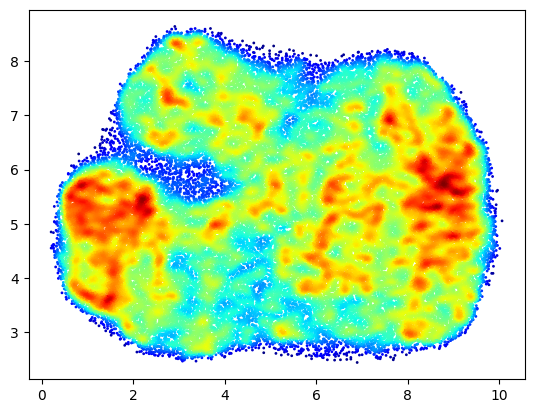

In [32]:
plot_2D_hist(E[:, 0], E[:, 1], colormap='jet', style='smooth')
plt.show()

8it [00:00, 367.51it/s]


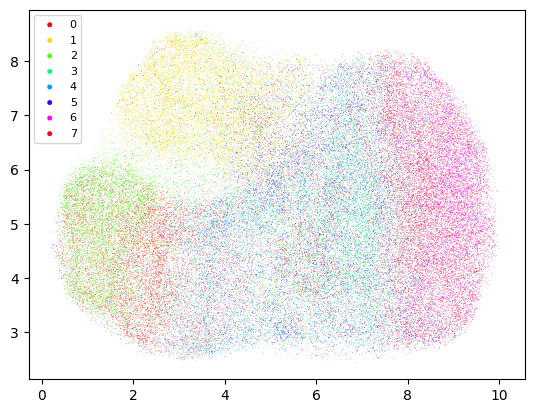

In [33]:
df = pd.read_csv('df_labels_Nuci,Nuc,Nsk,Mit,Gol,ER,Cel,Cyt_10000-max.csv')
labels = df['label'].to_numpy()
unq = np.unique(labels)
color_list = Cycle_Colors(len(unq))

plots = np.empty([len(unq)], dtype=object)
for i, lbl in tqdm(enumerate(unq)):
    idx = np.where(labels == lbl)
    plots[i] = plt.scatter(E[idx, 0], E[idx, 1], color=color_list[i], s=0.2, edgecolors='none')
    # plt.show()
    # plt.axis('off')

plt.legend(plots, unq, fontsize=8, markerscale=8)
plt.show()

In [18]:
labels = pd.read_csv('df_labels_Nuci,Nuc,Nsk,Mit,Gol,ER,Cel,Cyt_10000-max.csv')
print(labels.columns)

Index(['name', 'label'], dtype='object')
